In [0]:
# upgrade tables bo read_hdf wymaga zaraz
!pip install --upgrade tables
!pip install eli5
!pip install xgboost  #model
!pip install hyperopt  #optymalizator

In [0]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import xgboost as xgb

from sklearn.metrics import mean_absolute_error as mae
from sklearn.model_selection import cross_val_score

from hyperopt import hp, fmin, tpe, STATUS_OK

import eli5
from eli5.sklearn import PermutationImportance


## wczytywanie danych

In [6]:
ls "/content/drive/My Drive/Colab Notebooks/dw_matrix/matrix_two/dw_matrix_car"

data/       day2_visualisation.ipynb  day4.ipynb  README.md
day1.ipynb  day3_first_model.ipynb    LICENSE


In [7]:
cd "/content/drive/My Drive/Colab Notebooks/dw_matrix/matrix_two/dw_matrix_car/data"

/content/drive/My Drive/Colab Notebooks/dw_matrix/matrix_two/dw_matrix_car/data


In [8]:
ls

car.h5


In [9]:
df = pd.read_hdf('car.h5')
df.shape

(106494, 155)

In [10]:
df.columns

Index(['breadcrumb', 'created_at', 'price_currency', 'price_details',
       'price_value', 'seller_address', 'seller_name', 'seller_type',
       'feature_czujniki-parkowania-przednie',
       'feature_poduszka-powietrzna-chroniąca-kolana',
       ...
       'param_pearl', 'param_stan', 'param_wersja', 'param_emisja-co2',
       'param_body-type', 'param_matowy', 'param_bezwypadkowy',
       'param_akryl-(niemetalizowany)', 'param_monthly-payment-value',
       'car_id'],
      dtype='object', length=155)

## features factorization

In [0]:
SUFFIX_CAT = '__cat'
for feat in df.columns:
  if isinstance(df[feat][0], list): continue
  
  factorized_values = df[feat].factorize()[0]
  if SUFFIX_CAT in feat:
    df[feat] = factorized_values
  else:
    df[feat+SUFFIX_CAT] = factorized_values

In [12]:
cat_feats = [x for x in df.columns if SUFFIX_CAT in x]
# bez cen
cat_feats = [x for x in cat_feats if 'price' not in x]
len(cat_feats)

151

In [0]:
# zmienne numeryczne lepiej nie faktoryzować, bo tracimy informacje o wzajemnych odległościach
df['param_rok-produkcji'] = df['param_rok-produkcji'].map(lambda x: -1 if str(x) == 'None' else int(x))
df['param_moc'] = df['param_moc'].map(lambda x: -1 if str(x) == 'None' else int(str(x).split(' ')[0]))
df['param_pojemność-skokowa'] = df['param_pojemność-skokowa'].map(lambda x: -1 if str(x) == 'None' else int(str(x).split('cm')[0].replace(' ','')))

In [0]:
def run_model(model, feats=cat_feats):
  X = df[feats].values
  y = df['price_value'].values
  scores = cross_val_score(model, X, y, cv=3, scoring='neg_mean_absolute_error')
  return np.mean(scores), np.std(scores)

In [0]:
feats = ['param_napęd__cat','param_rok-produkcji','param_stan__cat','param_skrzynia-biegów__cat','param_faktura-vat__cat','param_moc','param_marka-pojazdu__cat','feature_kamera-cofania__cat','param_typ__cat','param_pojemność-skokowa','seller_name__cat','feature_wspomaganie-kierownicy__cat','param_model-pojazdu__cat','param_wersja__cat','param_kod-silnika__cat','feature_system-start-stop__cat','feature_asystent-pasa-ruchu__cat','feature_czujniki-parkowania-przednie__cat','feature_łopatki-zmiany-biegów__cat','feature_regulowane-zawieszenie__cat']

##XGBoost

In [16]:
xgb_params = {
    'max_depth': 5,
    'n_estimators': 50,
    'learning_rate': 0.1,
    'random_state': 0,
    'seed': 0
}
run_model(xgb.XGBRegressor(**xgb_params), feats)

[08:38:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:38:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:39:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


(-9569.227198767323, 72.83561801421891)

## Hyperopt

In [15]:
def obj_func(params):
  print("Training with params: ")
  print(params)

  mean_mae, score_std = run_model(xgb.XGBRegressor(**params), feats)

  return {'loss': np.abs(mean_mae), 'status': STATUS_OK}

#space
xgb_reg_params = {
    'learning_rate':    hp.choice('learning_rate',      np.arange(0.05, 0.31, 0.05)),
    'max_depth':        hp.choice('max_depth',          np.arange(5,16,1, dtype=int)),
    'subsample':        hp.quniform('subsample',        0.5, 1, 0.05),
    'colsaple_bytree':  hp.quniform('colsample_bytree', 0.5, 1, 0.05),
    'objective':        'reg:squarederror',
    'n_estimators':     100,
    'seed':             0,
    'tree_method':      'gpu_hist'
}
# 'tree_method': 'gpu_hist' użyje GPU o ile zmieniony w runtime

## run
#best = fmin(obj_func, xgb_reg_params, algo=tpe.suggest, max_evals=25)
# wg: https://github.com/hyperopt/hyperopt/issues/530
best = fmin(obj_func, xgb_reg_params, algo=tpe.suggest, max_evals=25, return_argmin=False)
best

Training with params: 
{'colsaple_bytree': 0.8500000000000001, 'learning_rate': 0.3, 'max_depth': 9, 'n_estimators': 100, 'objective': 'reg:squarederror', 'seed': 0, 'subsample': 0.9500000000000001, 'tree_method': 'gpu_hist'}
Training with params: 
{'colsaple_bytree': 0.8, 'learning_rate': 0.15000000000000002, 'max_depth': 10, 'n_estimators': 100, 'objective': 'reg:squarederror', 'seed': 0, 'subsample': 0.8500000000000001, 'tree_method': 'gpu_hist'}
Training with params: 
{'colsaple_bytree': 0.55, 'learning_rate': 0.15000000000000002, 'max_depth': 7, 'n_estimators': 100, 'objective': 'reg:squarederror', 'seed': 0, 'subsample': 0.8500000000000001, 'tree_method': 'gpu_hist'}
Training with params: 
{'colsaple_bytree': 1.0, 'learning_rate': 0.3, 'max_depth': 9, 'n_estimators': 100, 'objective': 'reg:squarederror', 'seed': 0, 'subsample': 0.8500000000000001, 'tree_method': 'gpu_hist'}
Training with params: 
{'colsaple_bytree': 0.8, 'learning_rate': 0.15000000000000002, 'max_depth': 10, 'n_e

{'colsaple_bytree': 0.8500000000000001,
 'learning_rate': 0.1,
 'max_depth': 15,
 'n_estimators': 100,
 'objective': 'reg:squarederror',
 'seed': 0,
 'subsample': 0.7000000000000001,
 'tree_method': 'gpu_hist'}

In [16]:
run_model(xgb.XGBRegressor(**best), feats)

(-7586.455579423336, 53.57928381493533)

## dodaję moje modyfikacje do features

In [17]:
# EUR
df = df[ df['price_currency'] != 'EUR' ]
df.shape

(106290, 309)

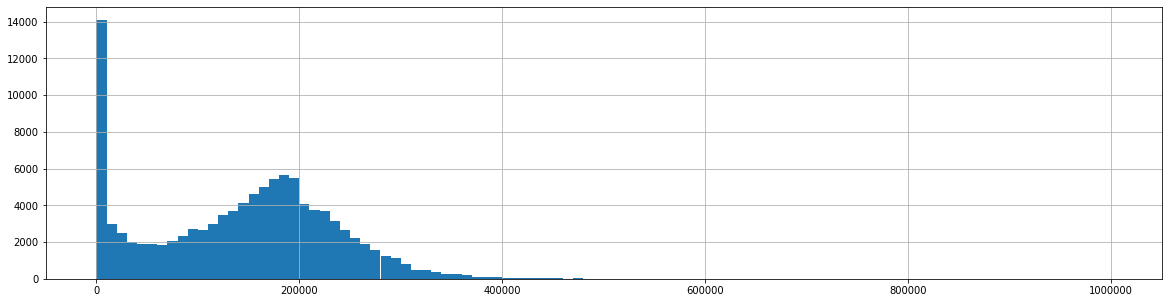

In [18]:
#param_prebieg_int
df['param_przebieg_int'] = df['param_przebieg'].map(lambda x: int(str(x).replace("km","").replace(" ", "")) if x else 0).astype(int)
# odcinam odstające wartości powyżej 1mln
df['param_przebieg_int'] = df['param_przebieg_int'].map(lambda x: x if x < 1000000 else -1)  #do modelu nie może być None, więc daję -1 znaczące brak
df.param_przebieg_int.hist(bins=100, figsize=(20,5));

In [19]:
# biorę tylko te ~20 o największym wpływie po dodani moich kolumn
feats = ['param_rok-produkcji','param_moc','param_przebieg_int','param_pojemność-skokowa','param_marka-pojazdu__cat','param_napęd__cat','param_rodzaj-paliwa__cat','param_kod-silnika__cat','param_wersja__cat','param_typ__cat','param_uszkodzony__cat','param_skrzynia-biegów__cat','seller_name__cat','param_bezwypadkowy__cat','param_model-pojazdu__cat','feature_czujniki-parkowania-przednie__cat','param_faktura-vat__cat','param_pojemność-skokowa__cat','feature_asystent-pasa-ruchu__cat','feature_kamera-cofania__cat']
run_model(xgb.XGBRegressor(**xgb_params), feats)

[08:40:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:40:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:40:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


(-8888.965998494477, 61.35790253138393)

tearaz hyperoptem optymalizacja parametrów modelu, 
przed optymalizacją było:
(-8888.965998494477, 61.35790253138393)

In [21]:
def obj_func(params):
  print("Training with params: ")
  print(params)

  mean_mae, score_std = run_model(xgb.XGBRegressor(**params), feats)

  return {'loss': np.abs(mean_mae), 'status': STATUS_OK}

#space
xgb_reg_params = {
    'learning_rate':    hp.choice('learning_rate',      np.arange(0.05, 0.31, 0.05)),
    'max_depth':        hp.choice('max_depth',          np.arange(5,16,1, dtype=int)),
    'subsample':        hp.quniform('subsample',        0.5, 1, 0.05),
    'colsaple_bytree':  hp.quniform('colsample_bytree', 0.5, 1, 0.05),
    'objective':        'reg:squarederror',
    'n_estimators':     100,
    'seed':             0,
    'tree_method':      'gpu_hist'
}
# 'tree_method': 'gpu_hist' użyje GPU o ile zmieniony w runtime

## run
#best = fmin(obj_func, xgb_reg_params, algo=tpe.suggest, max_evals=25)
# wg: https://github.com/hyperopt/hyperopt/issues/530
best = fmin(obj_func, xgb_reg_params, algo=tpe.suggest, max_evals=25, return_argmin=False)
best

Training with params: 
{'colsaple_bytree': 0.75, 'learning_rate': 0.3, 'max_depth': 15, 'n_estimators': 100, 'objective': 'reg:squarederror', 'seed': 0, 'subsample': 0.5, 'tree_method': 'gpu_hist'}
Training with params: 
{'colsaple_bytree': 0.75, 'learning_rate': 0.2, 'max_depth': 14, 'n_estimators': 100, 'objective': 'reg:squarederror', 'seed': 0, 'subsample': 0.7000000000000001, 'tree_method': 'gpu_hist'}
Training with params: 
{'colsaple_bytree': 0.5, 'learning_rate': 0.25, 'max_depth': 8, 'n_estimators': 100, 'objective': 'reg:squarederror', 'seed': 0, 'subsample': 0.9500000000000001, 'tree_method': 'gpu_hist'}
Training with params: 
{'colsaple_bytree': 1.0, 'learning_rate': 0.2, 'max_depth': 9, 'n_estimators': 100, 'objective': 'reg:squarederror', 'seed': 0, 'subsample': 0.65, 'tree_method': 'gpu_hist'}
Training with params: 
{'colsaple_bytree': 0.9, 'learning_rate': 0.2, 'max_depth': 10, 'n_estimators': 100, 'objective': 'reg:squarederror', 'seed': 0, 'subsample': 1.0, 'tree_meth

{'colsaple_bytree': 0.9500000000000001,
 'learning_rate': 0.15000000000000002,
 'max_depth': 12,
 'n_estimators': 100,
 'objective': 'reg:squarederror',
 'seed': 0,
 'subsample': 1.0,
 'tree_method': 'gpu_hist'}

In [22]:
run_model(xgb.XGBRegressor(**best), feats)

(-6705.428548550925, 68.4404322368238)